In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn.functional as F

# Adam

torch.set_default_dtype(torch.float64)
interp_type = 'bilinear'

eps = 1

def f(X,Y):
    return -eps - 2*np.pi**2*torch.sin(np.pi*X)*torch.sin(np.pi*Y)

def f_(X):
    #return X**2 - 1
    #return X**2
    return torch.sin(np.pi*X)


n_grids = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
#n_grids = [10,15,20,25]
#n_grids = [1000]

errors = []
errors_test = []

ii = 0

for n_grid in n_grids:
    print("n_grid={}".format(n_grid))
    #n_grid = 400


    x = torch.linspace(-1,1,steps=n_grid)
    y = torch.linspace(-1,1,steps=n_grid)
    x_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    y_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    X, Y = torch.meshgrid(x, y)
    h = 2/(n_grid-1)
    
    # free parameters have size 2*(n_grid-2)
    def free2pad(free):
        shape = free.shape
        free_pad = torch.zeros(2, shape[1]+2)
        free_pad[:,1:-1] = free
        return free_pad
    
    def pad2free(free_pad):
        return free_pad[:,1:-1]
    
    def free2full(free, pad=True):
        shape = free.shape
        if pad:
            free_pad = torch.zeros(2, shape[1]+2)
            free_pad[:,1:-1] = free
        else:
            free_pad = free
        full = add(free_pad)
        return full

    # PDE 
    def Laplacian(full, h):
        Lapx = (full[2:,1:-1] + full[:-2,1:-1] - 2*full[1:-1,1:-1])/h**2
        Lapy = (full[1:-1,2:] + full[1:-1,:-2] - 2*full[1:-1,1:-1])/h**2
        Lap = Lapx + Lapy
        return Lap

    def Lap_loss(full, h, x, y):
        Lap_numerical = Laplacian(full,h)
        X, Y = torch.meshgrid(x[1:-1],y[1:-1])
        Lap_true = f(X,Y)
        #print(full.shape, Lap_numerical.shape, Lap_true.shape)
        #plt.matshow(torch.abs(Lap_numerical - Lap_true).detach().numpy())
        #plt.colorbar()
        return torch.mean((Lap_numerical-Lap_true)**2)
    
    # full have shape (2, n_grid)
    def add(free_pad):
        return free_pad[0,:].unsqueeze(dim=0) * free_pad[1,:].unsqueeze(dim=1)


    # initalize z as random parameters, note sequential training
    #z = g(X,Y)
    if ii == 0:
    #if True:
        #z = torch.stack([f_(x[1:-1]), f_(y[1:-1])])
        z = torch.normal(0,1,size=(2,n_grid-2))*0.001
        z = torch.nn.Parameter(z, requires_grad=True)
    else:
        z_pad = free2pad(z)
        z_pad = F.interpolate(z_pad.unsqueeze(dim=0).unsqueeze(dim=0), size=(2,n_grid), mode=interp_type, align_corners=True)[0,0]
        z = pad2free(z_pad)
        z = torch.nn.Parameter(z, requires_grad=True)
        
    ii = ii + 1
    
    # initialize adam (learning rate scaling lr~h**4), z as parameters
    lr = 1e-2*(10/n_grid)**4
    opt = torch.optim.Adam({z}, lr=lr, eps=1e-8)
    #opt = torch.optim.SGD({z}, lr=lr)
    
    # iterations here (learning rate decay)
    epochs = 50000
    switch_epoch = 5000
    log = 100
    best_loss = 1e20
    losses = []
    
    for i in range(epochs):
        if (i+1) % switch_epoch == 0:
            for opt_param in opt.param_groups:
                lr = lr * 0.5
                opt_param['lr'] = lr
        
        def loss_closure():
            opt.zero_grad()
            z_full = free2full(z)
            loss_train = Lap_loss(z_full, h, x, y)
            z_pad = free2pad(z)
            z_interp = F.interpolate(z_pad.unsqueeze(dim=0).unsqueeze(dim=0), size=(2,2*n_grid-1), mode=interp_type, align_corners=True)[0,0]
            z_test = z_interp[:,1:-1:2]
            z_test_full = free2full(z_test, pad=False)
            loss_test = Lap_loss(z_test_full, h, x_test, y_test)
            loss = (loss_test*(n_grid-3)**2 + loss_train*(n_grid-2)**2)/((n_grid-3)**2+(n_grid-2)**2)
            #loss = loss_test
            loss.backward()
            return loss
          # -------------------------------------------
        loss = loss_closure()
        opt.step(loss_closure)  # get loss, use to update wts
        if loss < best_loss:
            best_loss = loss
            best_epoch = i
            best_z = z.clone()
        if i % log == 0:
            print("Epoch: {}".format(i) + " | " + "Loss: {}".format(loss.detach().numpy()))
        losses.append(loss.detach().numpy())
    
    errors.append(best_loss.detach().numpy())
    
    torch.save(z, './poisson_mult_results/z_n_{}'.format(n_grid))
    torch.save(best_loss, './poisson_mult_results/eps_1_loss_n_{}'.format(eps, n_grid))


n_grid=10
Epoch: 0 | Loss: 133.5768169974237
Epoch: 100 | Loss: 1.6941679861503751
Epoch: 200 | Loss: 1.500080931234552
Epoch: 300 | Loss: 1.5000808866455455
Epoch: 400 | Loss: 1.5000808862999764
Epoch: 500 | Loss: 1.5000808862999755
Epoch: 600 | Loss: 1.500080886299976
Epoch: 700 | Loss: 1.500080886299976
Epoch: 800 | Loss: 1.5000808862999764
Epoch: 900 | Loss: 1.500080886299976
Epoch: 1000 | Loss: 1.5000808862999764
Epoch: 1100 | Loss: 1.500080886299976
Epoch: 1200 | Loss: 1.5000808862999762
Epoch: 1300 | Loss: 1.5000808862999768
Epoch: 1400 | Loss: 1.5000808862999755
Epoch: 1500 | Loss: 1.5000808862999764
Epoch: 1600 | Loss: 1.500080886299976
Epoch: 1700 | Loss: 1.5002232496560521
Epoch: 1800 | Loss: 1.500080917662897
Epoch: 1900 | Loss: 1.5000808863003154
Epoch: 2000 | Loss: 1.500080886299976
Epoch: 2100 | Loss: 1.500080886299975
Epoch: 2200 | Loss: 1.5000808863000084
Epoch: 2300 | Loss: 1.500084875992079
Epoch: 2400 | Loss: 1.5000808863532729
Epoch: 2500 | Loss: 1.5000808862999804

Epoch: 20900 | Loss: 1.500080886299976
Epoch: 21000 | Loss: 1.5000808862999753
Epoch: 21100 | Loss: 1.5000808862999764
Epoch: 21200 | Loss: 1.5000808862999762
Epoch: 21300 | Loss: 1.5000808862999764
Epoch: 21400 | Loss: 1.5000808871714972
Epoch: 21500 | Loss: 1.500080898478258
Epoch: 21600 | Loss: 1.5000808863003763
Epoch: 21700 | Loss: 1.5000808862999748
Epoch: 21800 | Loss: 1.5000808862999768
Epoch: 21900 | Loss: 1.500080886299976
Epoch: 22000 | Loss: 1.5000824041230616
Epoch: 22100 | Loss: 1.5000808863114665
Epoch: 22200 | Loss: 1.5000808862999793
Epoch: 22300 | Loss: 1.5000808862999764
Epoch: 22400 | Loss: 1.5000840459840439
Epoch: 22500 | Loss: 1.5000808896856288
Epoch: 22600 | Loss: 1.500080919770102
Epoch: 22700 | Loss: 1.5000808922389863
Epoch: 22800 | Loss: 1.500081120163658
Epoch: 22900 | Loss: 1.5000808940957302
Epoch: 23000 | Loss: 1.5000808910841275
Epoch: 23100 | Loss: 1.5000809021617647
Epoch: 23200 | Loss: 1.5000808957896306
Epoch: 23300 | Loss: 1.500080887868718
Epoch:

Epoch: 41500 | Loss: 1.5000811353687062
Epoch: 41600 | Loss: 1.5000808863121144
Epoch: 41700 | Loss: 1.5000808862999773
Epoch: 41800 | Loss: 1.5000808862999764
Epoch: 41900 | Loss: 1.5000808862999755
Epoch: 42000 | Loss: 1.500080886299976
Epoch: 42100 | Loss: 1.5000808866148103
Epoch: 42200 | Loss: 1.5000808862999855
Epoch: 42300 | Loss: 1.500080886299976
Epoch: 42400 | Loss: 1.5000808862999944
Epoch: 42500 | Loss: 1.5000808867513589
Epoch: 42600 | Loss: 1.5000808908778198
Epoch: 42700 | Loss: 1.5000808871678335
Epoch: 42800 | Loss: 1.5000808887518473
Epoch: 42900 | Loss: 1.5000808885996266
Epoch: 43000 | Loss: 1.5000808864047106
Epoch: 43100 | Loss: 1.5000808863004556
Epoch: 43200 | Loss: 1.5000808963522962
Epoch: 43300 | Loss: 1.5000808863056172
Epoch: 43400 | Loss: 1.5000808870828728
Epoch: 43500 | Loss: 1.5000808863091069
Epoch: 43600 | Loss: 1.5000808864350563
Epoch: 43700 | Loss: 1.5000808978729392
Epoch: 43800 | Loss: 1.5000808863004655
Epoch: 43900 | Loss: 1.5000809109345041
Ep

Epoch: 12400 | Loss: 1.0214770752617626
Epoch: 12500 | Loss: 1.0214770713708292
Epoch: 12600 | Loss: 1.0214771939440916
Epoch: 12700 | Loss: 1.0214770713897539
Epoch: 12800 | Loss: 1.021477877111151
Epoch: 12900 | Loss: 1.0214770717527064
Epoch: 13000 | Loss: 1.0214773873034735
Epoch: 13100 | Loss: 1.021477071360803
Epoch: 13200 | Loss: 1.021504009316953
Epoch: 13300 | Loss: 1.0214770721432862
Epoch: 13400 | Loss: 1.0214770713529384
Epoch: 13500 | Loss: 1.02147743249211
Epoch: 13600 | Loss: 1.0214770714036008
Epoch: 13700 | Loss: 1.0214772005061332
Epoch: 13800 | Loss: 1.0214770714777877
Epoch: 13900 | Loss: 1.0214871246888197
Epoch: 14000 | Loss: 1.0214770716526171
Epoch: 14100 | Loss: 1.0214786332009045
Epoch: 14200 | Loss: 1.0214770715400057
Epoch: 14300 | Loss: 1.0214771666759044
Epoch: 14400 | Loss: 1.0214863034096904
Epoch: 14500 | Loss: 1.0214796927314682
Epoch: 14600 | Loss: 1.0214796196093083
Epoch: 14700 | Loss: 1.0214770902709087
Epoch: 14800 | Loss: 1.021477094409754
Epoch:

Epoch: 33000 | Loss: 1.0214770713628114
Epoch: 33100 | Loss: 1.0214770722332491
Epoch: 33200 | Loss: 1.021477071353714
Epoch: 33300 | Loss: 1.0214770722157698
Epoch: 33400 | Loss: 1.021477071459458
Epoch: 33500 | Loss: 1.021477072214916
Epoch: 33600 | Loss: 1.021477108252802
Epoch: 33700 | Loss: 1.0214770713554513
Epoch: 33800 | Loss: 1.0214770721025526
Epoch: 33900 | Loss: 1.021477071357702
Epoch: 34000 | Loss: 1.0214771030186216
Epoch: 34100 | Loss: 1.0214770713577939
Epoch: 34200 | Loss: 1.0214770713686656
Epoch: 34300 | Loss: 1.0214770714782557
Epoch: 34400 | Loss: 1.0214770713526793
Epoch: 34500 | Loss: 1.0214770729070641
Epoch: 34600 | Loss: 1.0214770713527166
Epoch: 34700 | Loss: 1.021477096645045
Epoch: 34800 | Loss: 1.0214770713657755
Epoch: 34900 | Loss: 1.0214770713526828
Epoch: 35000 | Loss: 1.021477071362589
Epoch: 35100 | Loss: 1.0214770713526835
Epoch: 35200 | Loss: 1.0214770713526753
Epoch: 35300 | Loss: 1.0214770713526768
Epoch: 35400 | Loss: 1.0214770713526755
Epoch: 

Epoch: 3700 | Loss: 1.0037355732353868
Epoch: 3800 | Loss: 1.0037355732350701
Epoch: 3900 | Loss: 1.0037355735995168
Epoch: 4000 | Loss: 1.003735574017161
Epoch: 4100 | Loss: 1.0037355732349986
Epoch: 4200 | Loss: 1.0037355732349835
Epoch: 4300 | Loss: 1.0037355732349815
Epoch: 4400 | Loss: 1.0037355732349884
Epoch: 4500 | Loss: 1.0037355807998607
Epoch: 4600 | Loss: 1.0037355732353284
Epoch: 4700 | Loss: 1.0037355732349815
Epoch: 4800 | Loss: 1.0037355732349815
Epoch: 4900 | Loss: 1.0037355732349857
Epoch: 5000 | Loss: 1.0037355752071428
Epoch: 5100 | Loss: 1.0037355732351343
Epoch: 5200 | Loss: 1.0037355732349817
Epoch: 5300 | Loss: 1.0037355732349826
Epoch: 5400 | Loss: 1.0037355732349824
Epoch: 5500 | Loss: 1.0037355732349826
Epoch: 5600 | Loss: 1.0037355732349809
Epoch: 5700 | Loss: 1.0037355732349809
Epoch: 5800 | Loss: 1.0037355732349813
Epoch: 5900 | Loss: 1.0037355732349826
Epoch: 6000 | Loss: 1.0037355732349806
Epoch: 6100 | Loss: 1.0037355732349797
Epoch: 6200 | Loss: 1.0037

Epoch: 24500 | Loss: 1.0037355741544558
Epoch: 24600 | Loss: 1.0037355741070138
Epoch: 24700 | Loss: 1.00373557941518
Epoch: 24800 | Loss: 1.0037355737458251
Epoch: 24900 | Loss: 1.0037355736163762
Epoch: 25000 | Loss: 1.0037355732940465
Epoch: 25100 | Loss: 1.0037355732349917
Epoch: 25200 | Loss: 1.0037355732349804
Epoch: 25300 | Loss: 1.0037355732349809
Epoch: 25400 | Loss: 1.0037355732349822
Epoch: 25500 | Loss: 1.0037355732349817
Epoch: 25600 | Loss: 1.0037355732349822
Epoch: 25700 | Loss: 1.0037355732349822
Epoch: 25800 | Loss: 1.0037355732349817
Epoch: 25900 | Loss: 1.0037355732349815
Epoch: 26000 | Loss: 1.0037355732349833
Epoch: 26100 | Loss: 1.0037355732349833
Epoch: 26200 | Loss: 1.0037355732349817
Epoch: 26300 | Loss: 1.0037355732349822
Epoch: 26400 | Loss: 1.0037355732349822
Epoch: 26500 | Loss: 1.0037355946437654
Epoch: 26600 | Loss: 1.0037355732380653
Epoch: 26700 | Loss: 1.0037355732349793
Epoch: 26800 | Loss: 1.0037355815741444
Epoch: 26900 | Loss: 1.003735574551216
Epo

Epoch: 45100 | Loss: 1.0037355732349822
Epoch: 45200 | Loss: 1.0037355732349809
Epoch: 45300 | Loss: 1.003735573234983
Epoch: 45400 | Loss: 1.0037355732349817
Epoch: 45500 | Loss: 1.0037355732349822
Epoch: 45600 | Loss: 1.0037355732349815
Epoch: 45700 | Loss: 1.003735573234983
Epoch: 45800 | Loss: 1.0037355732349822
Epoch: 45900 | Loss: 1.0037355732349815
Epoch: 46000 | Loss: 1.0037355732349817
Epoch: 46100 | Loss: 1.0037355732349813
Epoch: 46200 | Loss: 1.0037355732349817
Epoch: 46300 | Loss: 1.0037355732349826
Epoch: 46400 | Loss: 1.0037355732349822
Epoch: 46500 | Loss: 1.0037355732523578
Epoch: 46600 | Loss: 1.0037355732349822
Epoch: 46700 | Loss: 1.0037355732349822
Epoch: 46800 | Loss: 1.0037355732349809
Epoch: 46900 | Loss: 1.003735573239726
Epoch: 47000 | Loss: 1.0037355732349817
Epoch: 47100 | Loss: 1.003735573258112
Epoch: 47200 | Loss: 1.0037355732354822
Epoch: 47300 | Loss: 1.0037355732352138
Epoch: 47400 | Loss: 1.0037355732380229
Epoch: 47500 | Loss: 1.0037355732837254
Epoc

Epoch: 16000 | Loss: 1.001110331634331
Epoch: 16100 | Loss: 1.001110331634331
Epoch: 16200 | Loss: 1.001110331634329
Epoch: 16300 | Loss: 1.001110331634329
Epoch: 16400 | Loss: 1.0011103316343297
Epoch: 16500 | Loss: 1.0011103872550344
Epoch: 16600 | Loss: 1.0011103316638776
Epoch: 16700 | Loss: 1.0011103316636492
Epoch: 16800 | Loss: 1.0011103331207103
Epoch: 16900 | Loss: 1.0011103339668546
Epoch: 17000 | Loss: 1.00111037430473
Epoch: 17100 | Loss: 1.0011103317852827
Epoch: 17200 | Loss: 1.0011103332639064
Epoch: 17300 | Loss: 1.001110337571911
Epoch: 17400 | Loss: 1.0011103380260897
Epoch: 17500 | Loss: 1.0011103869451152
Epoch: 17600 | Loss: 1.001110341971435
Epoch: 17700 | Loss: 1.0011103350066841
Epoch: 17800 | Loss: 1.0011104218750235
Epoch: 17900 | Loss: 1.0011103329944206
Epoch: 18000 | Loss: 1.0011103326448134
Epoch: 18100 | Loss: 1.0011103316436103
Epoch: 18200 | Loss: 1.001110485972303
Epoch: 18300 | Loss: 1.0011103316421777
Epoch: 18400 | Loss: 1.0011103317005725
Epoch: 18

Epoch: 36600 | Loss: 1.0011103316343932
Epoch: 36700 | Loss: 1.0011103316343302
Epoch: 36800 | Loss: 1.0011103316343308
Epoch: 36900 | Loss: 1.0011103316514751
Epoch: 37000 | Loss: 1.001110331635179
Epoch: 37100 | Loss: 1.0011103316346854
Epoch: 37200 | Loss: 1.0011103316440575
Epoch: 37300 | Loss: 1.001110332066413
Epoch: 37400 | Loss: 1.0011103316923795
Epoch: 37500 | Loss: 1.0011103316890346
Epoch: 37600 | Loss: 1.001110331872163
Epoch: 37700 | Loss: 1.0011103317842844
Epoch: 37800 | Loss: 1.0011103320158043
Epoch: 37900 | Loss: 1.0011103316400984
Epoch: 38000 | Loss: 1.0011103317171646
Epoch: 38100 | Loss: 1.0011103318397465
Epoch: 38200 | Loss: 1.001110331682231
Epoch: 38300 | Loss: 1.001110331639595
Epoch: 38400 | Loss: 1.0011103318669463
Epoch: 38500 | Loss: 1.0011103318256558
Epoch: 38600 | Loss: 1.0011103316393186
Epoch: 38700 | Loss: 1.0011103316352987
Epoch: 38800 | Loss: 1.001110331748107
Epoch: 38900 | Loss: 1.0011103317006271
Epoch: 39000 | Loss: 1.001110331929435
Epoch: 

Epoch: 7500 | Loss: 1.0004383183954457
Epoch: 7600 | Loss: 1.0004382819548556
Epoch: 7700 | Loss: 1.0004382867538577
Epoch: 7800 | Loss: 1.0004382784113772
Epoch: 7900 | Loss: 1.0004382670104262
Epoch: 8000 | Loss: 1.0004383174389786
Epoch: 8100 | Loss: 1.000438257690368
Epoch: 8200 | Loss: 1.0004383171855358
Epoch: 8300 | Loss: 1.0004382666877008
Epoch: 8400 | Loss: 1.0004382586241833
Epoch: 8500 | Loss: 1.000438275406005
Epoch: 8600 | Loss: 1.0004383102372891
Epoch: 8700 | Loss: 1.000438323524262
Epoch: 8800 | Loss: 1.0004382684164412
Epoch: 8900 | Loss: 1.0004383389115346
Epoch: 9000 | Loss: 1.000438332013002
Epoch: 9100 | Loss: 1.0004382864371855
Epoch: 9200 | Loss: 1.0004382593308132
Epoch: 9300 | Loss: 1.000438274822361
Epoch: 9400 | Loss: 1.0004386134307046
Epoch: 9500 | Loss: 1.000438271057194
Epoch: 9600 | Loss: 1.0004383104178673
Epoch: 9700 | Loss: 1.000438273839325
Epoch: 9800 | Loss: 1.0004383152812375
Epoch: 9900 | Loss: 1.0004382771162086
Epoch: 10000 | Loss: 1.000438258

Epoch: 28200 | Loss: 1.0004382558121978
Epoch: 28300 | Loss: 1.000438255952835
Epoch: 28400 | Loss: 1.0004382558425953
Epoch: 28500 | Loss: 1.0004382559718545
Epoch: 28600 | Loss: 1.0004382569698624
Epoch: 28700 | Loss: 1.0004382576184163
Epoch: 28800 | Loss: 1.0004382558338314
Epoch: 28900 | Loss: 1.0004382557862217
Epoch: 29000 | Loss: 1.0004382558176559
Epoch: 29100 | Loss: 1.0004382560232021
Epoch: 29200 | Loss: 1.0004382557788243
Epoch: 29300 | Loss: 1.0004382557717788
Epoch: 29400 | Loss: 1.0004382560167127
Epoch: 29500 | Loss: 1.0004382558831169
Epoch: 29600 | Loss: 1.0004382560058727
Epoch: 29700 | Loss: 1.000438256484469
Epoch: 29800 | Loss: 1.0004382564089362
Epoch: 29900 | Loss: 1.000438256384874
Epoch: 30000 | Loss: 1.000438255772169
Epoch: 30100 | Loss: 1.0004382557642049
Epoch: 30200 | Loss: 1.0004382557642058
Epoch: 30300 | Loss: 1.0004382557642069
Epoch: 30400 | Loss: 1.0004382557642066
Epoch: 30500 | Loss: 1.0004382557642073
Epoch: 30600 | Loss: 1.0004382557642069
Epoc

Epoch: 48800 | Loss: 1.0004382557644853
Epoch: 48900 | Loss: 1.0004382557644207
Epoch: 49000 | Loss: 1.0004382557679143
Epoch: 49100 | Loss: 1.0004382557645275
Epoch: 49200 | Loss: 1.000438255764485
Epoch: 49300 | Loss: 1.0004382557655063
Epoch: 49400 | Loss: 1.0004382557668792
Epoch: 49500 | Loss: 1.0004382557655036
Epoch: 49600 | Loss: 1.0004382557703484
Epoch: 49700 | Loss: 1.0004382557690514
Epoch: 49800 | Loss: 1.0004382557666145
Epoch: 49900 | Loss: 1.0004382557661713
n_grid=60
Epoch: 0 | Loss: 1.1992813995057818
Epoch: 100 | Loss: 1.0060447371701087
Epoch: 200 | Loss: 1.000470588171574
Epoch: 300 | Loss: 1.000318794121036
Epoch: 400 | Loss: 1.000312257093224
Epoch: 500 | Loss: 1.0003099223152434
Epoch: 600 | Loss: 1.0003077909556322
Epoch: 700 | Loss: 1.0003056830795514
Epoch: 800 | Loss: 1.0003035572631516
Epoch: 900 | Loss: 1.0003013857726786
Epoch: 1000 | Loss: 1.0002991509975336
Epoch: 1100 | Loss: 1.0002968445153764
Epoch: 1200 | Loss: 1.0002944649816294
Epoch: 1300 | Loss:

Epoch: 19700 | Loss: 1.0002062470780093
Epoch: 19800 | Loss: 1.000206241435801
Epoch: 19900 | Loss: 1.0002062419199729
Epoch: 20000 | Loss: 1.00020624087282
Epoch: 20100 | Loss: 1.00020624086354
Epoch: 20200 | Loss: 1.000206240863527
Epoch: 20300 | Loss: 1.000206240863528
Epoch: 20400 | Loss: 1.000206240863528
Epoch: 20500 | Loss: 1.0002062408635273
Epoch: 20600 | Loss: 1.0002062408635237
Epoch: 20700 | Loss: 1.000206240863526
Epoch: 20800 | Loss: 1.0002062408635273
Epoch: 20900 | Loss: 1.0002062408635275
Epoch: 21000 | Loss: 1.0002062408635273
Epoch: 21100 | Loss: 1.0002062408635275
Epoch: 21200 | Loss: 1.000206240863525
Epoch: 21300 | Loss: 1.0002062408635264
Epoch: 21400 | Loss: 1.0002062408635264
Epoch: 21500 | Loss: 1.0002062525129574
Epoch: 21600 | Loss: 1.0002062408637071
Epoch: 21700 | Loss: 1.0002062408648043
Epoch: 21800 | Loss: 1.0002062421357583
Epoch: 21900 | Loss: 1.0002062421941935
Epoch: 22000 | Loss: 1.0002062422669389
Epoch: 22100 | Loss: 1.0002062408924095
Epoch: 222

Epoch: 40400 | Loss: 1.0002062408635257
Epoch: 40500 | Loss: 1.000206240863526
Epoch: 40600 | Loss: 1.000206240863525
Epoch: 40700 | Loss: 1.0002062408635244
Epoch: 40800 | Loss: 1.0002062408635273
Epoch: 40900 | Loss: 1.0002062408635264
Epoch: 41000 | Loss: 1.000206240863527
Epoch: 41100 | Loss: 1.0002062408635268
Epoch: 41200 | Loss: 1.000206240863528
Epoch: 41300 | Loss: 1.0002062408635255
Epoch: 41400 | Loss: 1.000206240863528
Epoch: 41500 | Loss: 1.0002062408753745
Epoch: 41600 | Loss: 1.0002062408722492
Epoch: 41700 | Loss: 1.0002062408635262
Epoch: 41800 | Loss: 1.0002062408649304
Epoch: 41900 | Loss: 1.0002062408705312
Epoch: 42000 | Loss: 1.0002062408659163
Epoch: 42100 | Loss: 1.000206240867337
Epoch: 42200 | Loss: 1.0002062408644994
Epoch: 42300 | Loss: 1.0002062408637806
Epoch: 42400 | Loss: 1.0002062408646735
Epoch: 42500 | Loss: 1.000206240870148
Epoch: 42600 | Loss: 1.0002062408729748
Epoch: 42700 | Loss: 1.0002062408819024
Epoch: 42800 | Loss: 1.0002062408643324
Epoch: 

Epoch: 11300 | Loss: 1.0001094071891676
Epoch: 11400 | Loss: 1.000109407183909
Epoch: 11500 | Loss: 1.0001094328972178
Epoch: 11600 | Loss: 1.0001094074849648
Epoch: 11700 | Loss: 1.0001094071787715
Epoch: 11800 | Loss: 1.0001094116155413
Epoch: 11900 | Loss: 1.0001094481044115
Epoch: 12000 | Loss: 1.0001094073036874
Epoch: 12100 | Loss: 1.0001094087213258
Epoch: 12200 | Loss: 1.0001094149275183
Epoch: 12300 | Loss: 1.0001094179450651
Epoch: 12400 | Loss: 1.0001094336311573
Epoch: 12500 | Loss: 1.0001094120062668
Epoch: 12600 | Loss: 1.0001094251434066
Epoch: 12700 | Loss: 1.0001094254711371
Epoch: 12800 | Loss: 1.0001094143737372
Epoch: 12900 | Loss: 1.0001094180490901
Epoch: 13000 | Loss: 1.000109420060978
Epoch: 13100 | Loss: 1.000109411417037
Epoch: 13200 | Loss: 1.0001094102477754
Epoch: 13300 | Loss: 1.0001094102255192
Epoch: 13400 | Loss: 1.0001094085692002
Epoch: 13500 | Loss: 1.0001094155582024
Epoch: 13600 | Loss: 1.0001094147373315
Epoch: 13700 | Loss: 1.000109408154672
Epoc

Epoch: 32000 | Loss: 1.0001094072292898
Epoch: 32100 | Loss: 1.000109407243429
Epoch: 32200 | Loss: 1.0001094071874987
Epoch: 32300 | Loss: 1.0001094071747767
Epoch: 32400 | Loss: 1.000109407175926
Epoch: 32500 | Loss: 1.0001094071761052
Epoch: 32600 | Loss: 1.0001094072290988
Epoch: 32700 | Loss: 1.0001094072021974
Epoch: 32800 | Loss: 1.000109407239528
Epoch: 32900 | Loss: 1.0001094071930436
Epoch: 33000 | Loss: 1.0001094071770813
Epoch: 33100 | Loss: 1.0001094071797656
Epoch: 33200 | Loss: 1.00010940718163
Epoch: 33300 | Loss: 1.0001094071891978
Epoch: 33400 | Loss: 1.0001094072079868
Epoch: 33500 | Loss: 1.0001094071771959
Epoch: 33600 | Loss: 1.0001094072066459
Epoch: 33700 | Loss: 1.0001094072479437
Epoch: 33800 | Loss: 1.0001094072544956
Epoch: 33900 | Loss: 1.000109407181201
Epoch: 34000 | Loss: 1.000109407189331
Epoch: 34100 | Loss: 1.0001094071843917
Epoch: 34200 | Loss: 1.000109407195167
Epoch: 34300 | Loss: 1.000109407228902
Epoch: 34400 | Loss: 1.0001094072098862
Epoch: 34

Epoch: 2700 | Loss: 1.00008180374152
Epoch: 2800 | Loss: 1.0000815504558627
Epoch: 2900 | Loss: 1.0000810693118687
Epoch: 3000 | Loss: 1.0000806951642813
Epoch: 3100 | Loss: 1.0000803103324323
Epoch: 3200 | Loss: 1.0000799265338198
Epoch: 3300 | Loss: 1.0000794987651207
Epoch: 3400 | Loss: 1.0000790896872724
Epoch: 3500 | Loss: 1.0000787335172803
Epoch: 3600 | Loss: 1.000078255802299
Epoch: 3700 | Loss: 1.0000778029612534
Epoch: 3800 | Loss: 1.0000773669509087
Epoch: 3900 | Loss: 1.00007691645472
Epoch: 4000 | Loss: 1.0000764935092392
Epoch: 4100 | Loss: 1.0000760208272401
Epoch: 4200 | Loss: 1.0000755748036152
Epoch: 4300 | Loss: 1.000075097189832
Epoch: 4400 | Loss: 1.0000746310464057
Epoch: 4500 | Loss: 1.0000741706955634
Epoch: 4600 | Loss: 1.000073708426139
Epoch: 4700 | Loss: 1.0000732176427107
Epoch: 4800 | Loss: 1.0000727817669997
Epoch: 4900 | Loss: 1.0000722816720156
Epoch: 5000 | Loss: 1.0000718212781912
Epoch: 5100 | Loss: 1.0000715858293967
Epoch: 5200 | Loss: 1.0000713473

Epoch: 23500 | Loss: 1.0000633068297011
Epoch: 23600 | Loss: 1.0000633070522331
Epoch: 23700 | Loss: 1.0000633072011837
Epoch: 23800 | Loss: 1.000063306754126
Epoch: 23900 | Loss: 1.0000633069837408
Epoch: 24000 | Loss: 1.0000633067952072
Epoch: 24100 | Loss: 1.0000633068787235
Epoch: 24200 | Loss: 1.0000633071084724
Epoch: 24300 | Loss: 1.000063307186409
Epoch: 24400 | Loss: 1.0000633068845157
Epoch: 24500 | Loss: 1.0000633072516925
Epoch: 24600 | Loss: 1.0000633068018365
Epoch: 24700 | Loss: 1.0000633068436724
Epoch: 24800 | Loss: 1.0000633074386829
Epoch: 24900 | Loss: 1.000063307491631
Epoch: 25000 | Loss: 1.0000633067355518
Epoch: 25100 | Loss: 1.0000633067269358
Epoch: 25200 | Loss: 1.0000633067269216
Epoch: 25300 | Loss: 1.0000633067269191
Epoch: 25400 | Loss: 1.0000633067269245
Epoch: 25500 | Loss: 1.0000633067269193
Epoch: 25600 | Loss: 1.000063306726922
Epoch: 25700 | Loss: 1.0000633067269207
Epoch: 25800 | Loss: 1.000063306726925
Epoch: 25900 | Loss: 1.000063306726923
Epoch:

Epoch: 44200 | Loss: 1.000063306728138
Epoch: 44300 | Loss: 1.0000633067272824
Epoch: 44400 | Loss: 1.0000633067271492
Epoch: 44500 | Loss: 1.000063306728168
Epoch: 44600 | Loss: 1.0000633067302147
Epoch: 44700 | Loss: 1.0000633067270854
Epoch: 44800 | Loss: 1.000063306727143
Epoch: 44900 | Loss: 1.0000633067295954
Epoch: 45000 | Loss: 1.0000633067269311
Epoch: 45100 | Loss: 1.0000633067269231
Epoch: 45200 | Loss: 1.0000633067269225
Epoch: 45300 | Loss: 1.0000633067269187
Epoch: 45400 | Loss: 1.0000633067269222
Epoch: 45500 | Loss: 1.0000633067269242
Epoch: 45600 | Loss: 1.0000633067269187
Epoch: 45700 | Loss: 1.0000633067269264
Epoch: 45800 | Loss: 1.000063306726924
Epoch: 45900 | Loss: 1.0000633067269211
Epoch: 46000 | Loss: 1.0000633067269213
Epoch: 46100 | Loss: 1.0000633067269216
Epoch: 46200 | Loss: 1.0000633067269196
Epoch: 46300 | Loss: 1.000063306726922
Epoch: 46400 | Loss: 1.0000633067269222
Epoch: 46500 | Loss: 1.0000633067270424
Epoch: 46600 | Loss: 1.0000633067269218
Epoch

Epoch: 15100 | Loss: 1.0000391273718676
Epoch: 15200 | Loss: 1.000039127361183
Epoch: 15300 | Loss: 1.0000391273510885
Epoch: 15400 | Loss: 1.0000391273415774
Epoch: 15500 | Loss: 1.0000391273326517
Epoch: 15600 | Loss: 1.0000391273243328
Epoch: 15700 | Loss: 1.0000391273166342
Epoch: 15800 | Loss: 1.000039127309553
Epoch: 15900 | Loss: 1.0000391273030782
Epoch: 16000 | Loss: 1.0000391272972116
Epoch: 16100 | Loss: 1.0000391272919236
Epoch: 16200 | Loss: 1.0000391272872053
Epoch: 16300 | Loss: 1.0000391272830231
Epoch: 16400 | Loss: 1.0000391272793556
Epoch: 16500 | Loss: 1.0000391306633905
Epoch: 16600 | Loss: 1.0000391272740654
Epoch: 16700 | Loss: 1.000039127272457
Epoch: 16800 | Loss: 1.000039127662798
Epoch: 16900 | Loss: 1.0000391276433136
Epoch: 17000 | Loss: 1.0000391281423346
Epoch: 17100 | Loss: 1.0000391276969192
Epoch: 17200 | Loss: 1.000039127366399
Epoch: 17300 | Loss: 1.0000391273319733
Epoch: 17400 | Loss: 1.0000391282554093
Epoch: 17500 | Loss: 1.0000391274883953
Epoch

Epoch: 35800 | Loss: 1.000039127261303
Epoch: 35900 | Loss: 1.0000391272612934
Epoch: 36000 | Loss: 1.0000391272612987
Epoch: 36100 | Loss: 1.000039127261298
Epoch: 36200 | Loss: 1.0000391272612952
Epoch: 36300 | Loss: 1.0000391272612967
Epoch: 36400 | Loss: 1.0000391272613007
Epoch: 36500 | Loss: 1.000039127265461
Epoch: 36600 | Loss: 1.0000391272613103
Epoch: 36700 | Loss: 1.0000391272615707
Epoch: 36800 | Loss: 1.0000391272618856
Epoch: 36900 | Loss: 1.0000391272627596
Epoch: 37000 | Loss: 1.0000391272656068
Epoch: 37100 | Loss: 1.000039127268207
Epoch: 37200 | Loss: 1.0000391272638154
Epoch: 37300 | Loss: 1.0000391272616043
Epoch: 37400 | Loss: 1.000039127269947
Epoch: 37500 | Loss: 1.0000391272637947
Epoch: 37600 | Loss: 1.0000391272635305
Epoch: 37700 | Loss: 1.0000391272644353
Epoch: 37800 | Loss: 1.0000391272680293
Epoch: 37900 | Loss: 1.0000391272621114
Epoch: 38000 | Loss: 1.000039127262411
Epoch: 38100 | Loss: 1.0000391272665412
Epoch: 38200 | Loss: 1.00003912726242
Epoch: 3

Epoch: 6700 | Loss: 1.0000289526551422
Epoch: 6800 | Loss: 1.0000288641332593
Epoch: 6900 | Loss: 1.0000287730723632
Epoch: 7000 | Loss: 1.0000286801971774
Epoch: 7100 | Loss: 1.0000285857175726
Epoch: 7200 | Loss: 1.0000284941922737
Epoch: 7300 | Loss: 1.0000283990481453
Epoch: 7400 | Loss: 1.0000282970187553
Epoch: 7500 | Loss: 1.0000282015424178
Epoch: 7600 | Loss: 1.0000281001690294
Epoch: 7700 | Loss: 1.000028004002265
Epoch: 7800 | Loss: 1.0000279047459564
Epoch: 7900 | Loss: 1.0000278009001906
Epoch: 8000 | Loss: 1.0000277039191465
Epoch: 8100 | Loss: 1.0000276130907997
Epoch: 8200 | Loss: 1.0000275073952585
Epoch: 8300 | Loss: 1.0000274104125748
Epoch: 8400 | Loss: 1.000027315240762
Epoch: 8500 | Loss: 1.0000272181348997
Epoch: 8600 | Loss: 1.0000271248703922
Epoch: 8700 | Loss: 1.0000270283903065
Epoch: 8800 | Loss: 1.0000269451374222
Epoch: 8900 | Loss: 1.000026853371415
Epoch: 9000 | Loss: 1.0000267655913753
Epoch: 9100 | Loss: 1.0000266842680499
Epoch: 9200 | Loss: 1.000026

Epoch: 27400 | Loss: 1.0000254667053232
Epoch: 27500 | Loss: 1.0000254666988309
Epoch: 27600 | Loss: 1.000025466689304
Epoch: 27700 | Loss: 1.0000254667152488
Epoch: 27800 | Loss: 1.000025466809519
Epoch: 27900 | Loss: 1.0000254667222337
Epoch: 28000 | Loss: 1.0000254667164687
Epoch: 28100 | Loss: 1.000025466708688
Epoch: 28200 | Loss: 1.000025466688564
Epoch: 28300 | Loss: 1.000025466699775
Epoch: 28400 | Loss: 1.0000254667063126
Epoch: 28500 | Loss: 1.0000254666905652
Epoch: 28600 | Loss: 1.0000254666766168
Epoch: 28700 | Loss: 1.000025466691319
Epoch: 28800 | Loss: 1.0000254666782464
Epoch: 28900 | Loss: 1.000025466676867
Epoch: 29000 | Loss: 1.0000254666879984
Epoch: 29100 | Loss: 1.0000254666963204
Epoch: 29200 | Loss: 1.000025466681219
Epoch: 29300 | Loss: 1.0000254667034971
Epoch: 29400 | Loss: 1.0000254667182773
Epoch: 29500 | Loss: 1.0000254666857453
Epoch: 29600 | Loss: 1.0000254666897854
Epoch: 29700 | Loss: 1.0000254666952462
Epoch: 29800 | Loss: 1.0000254666955524
Epoch: 2

Epoch: 48100 | Loss: 1.0000254666741006
Epoch: 48200 | Loss: 1.0000254666740318
Epoch: 48300 | Loss: 1.0000254666741781
Epoch: 48400 | Loss: 1.0000254666741624
Epoch: 48500 | Loss: 1.0000254666741477
Epoch: 48600 | Loss: 1.0000254666740227
Epoch: 48700 | Loss: 1.0000254666741515
Epoch: 48800 | Loss: 1.000025466674273
Epoch: 48900 | Loss: 1.0000254666740858
Epoch: 49000 | Loss: 1.0000254666740294
Epoch: 49100 | Loss: 1.000025466674422
Epoch: 49200 | Loss: 1.0000254666741561
Epoch: 49300 | Loss: 1.000025466674311
Epoch: 49400 | Loss: 1.000025466674055
Epoch: 49500 | Loss: 1.0000254666742159
Epoch: 49600 | Loss: 1.0000254666740647
Epoch: 49700 | Loss: 1.0000254666740283
Epoch: 49800 | Loss: 1.0000254666742616
Epoch: 49900 | Loss: 1.0000254666742538
n_grid=110
Epoch: 0 | Loss: 1.0256952401331825
Epoch: 100 | Loss: 1.0060678514808508
Epoch: 200 | Loss: 1.0017280231945234
Epoch: 300 | Loss: 1.000488997679664
Epoch: 400 | Loss: 1.0001633326028538
Epoch: 500 | Loss: 1.0000705889569579
Epoch: 6

Epoch: 19000 | Loss: 1.00001728243794
Epoch: 19100 | Loss: 1.0000172823745153
Epoch: 19200 | Loss: 1.0000172820771944
Epoch: 19300 | Loss: 1.0000172821317406
Epoch: 19400 | Loss: 1.0000172818908242
Epoch: 19500 | Loss: 1.0000172820308606
Epoch: 19600 | Loss: 1.0000172818511408
Epoch: 19700 | Loss: 1.0000172820299569
Epoch: 19800 | Loss: 1.0000172816636923
Epoch: 19900 | Loss: 1.0000172817917277
Epoch: 20000 | Loss: 1.0000172814467905
Epoch: 20100 | Loss: 1.0000172814149046
Epoch: 20200 | Loss: 1.000017281387972
Epoch: 20300 | Loss: 1.0000172813609374
Epoch: 20400 | Loss: 1.0000172813338495
Epoch: 20500 | Loss: 1.000017281306789
Epoch: 20600 | Loss: 1.0000172812798047
Epoch: 20700 | Loss: 1.000017281252977
Epoch: 20800 | Loss: 1.0000172812263928
Epoch: 20900 | Loss: 1.0000172812001142
Epoch: 21000 | Loss: 1.0000172811742316
Epoch: 21100 | Loss: 1.0000172811488166
Epoch: 21200 | Loss: 1.000017281123947
Epoch: 21300 | Loss: 1.0000172810997037
Epoch: 21400 | Loss: 1.0000172810761674
Epoch:

Epoch: 39700 | Loss: 1.0000172808010153
Epoch: 39800 | Loss: 1.0000172807998058
Epoch: 39900 | Loss: 1.0000172807998648
Epoch: 40000 | Loss: 1.0000172807995624
Epoch: 40100 | Loss: 1.0000172807995533
Epoch: 40200 | Loss: 1.0000172807995595
Epoch: 40300 | Loss: 1.0000172807995573
Epoch: 40400 | Loss: 1.0000172807995513
Epoch: 40500 | Loss: 1.0000172807995507
Epoch: 40600 | Loss: 1.0000172807995458
Epoch: 40700 | Loss: 1.0000172807995498
Epoch: 40800 | Loss: 1.0000172807995538
Epoch: 40900 | Loss: 1.00001728079955
Epoch: 41000 | Loss: 1.0000172807995573
Epoch: 41100 | Loss: 1.0000172807995513
Epoch: 41200 | Loss: 1.00001728079955
Epoch: 41300 | Loss: 1.0000172807995473
Epoch: 41400 | Loss: 1.0000172807995507
Epoch: 41500 | Loss: 1.0000172808006547
Epoch: 41600 | Loss: 1.0000172807995495
Epoch: 41700 | Loss: 1.0000172808006607
Epoch: 41800 | Loss: 1.0000172807997478
Epoch: 41900 | Loss: 1.000017280800405
Epoch: 42000 | Loss: 1.0000172808001222
Epoch: 42100 | Loss: 1.0000172807996046
Epoch

Epoch: 10600 | Loss: 1.0000128599824454
Epoch: 10700 | Loss: 1.000012840197031
Epoch: 10800 | Loss: 1.0000128199862501
Epoch: 10900 | Loss: 1.0000127993705972
Epoch: 11000 | Loss: 1.0000127783737114
Epoch: 11100 | Loss: 1.0000127570224757
Epoch: 11200 | Loss: 1.0000127353471346
Epoch: 11300 | Loss: 1.0000127133813423
Epoch: 11400 | Loss: 1.0000126911622307
Epoch: 11500 | Loss: 1.0000126714437128
Epoch: 11600 | Loss: 1.0000126477980562
Epoch: 11700 | Loss: 1.000012626732656
Epoch: 11800 | Loss: 1.0000126060489452
Epoch: 11900 | Loss: 1.00001258780894
Epoch: 12000 | Loss: 1.0000125666359974
Epoch: 12100 | Loss: 1.0000125459634697
Epoch: 12200 | Loss: 1.0000125278313488
Epoch: 12300 | Loss: 1.0000125086728968
Epoch: 12400 | Loss: 1.000012491034079
Epoch: 12500 | Loss: 1.0000124748928014
Epoch: 12600 | Loss: 1.0000124583645442
Epoch: 12700 | Loss: 1.0000124411994975
Epoch: 12800 | Loss: 1.0000124272664042
Epoch: 12900 | Loss: 1.0000124118308136
Epoch: 13000 | Loss: 1.0000123964675227
Epoch

Epoch: 31300 | Loss: 1.0000121353005913
Epoch: 31400 | Loss: 1.0000121352997537
Epoch: 31500 | Loss: 1.0000121353023608
Epoch: 31600 | Loss: 1.0000121353000901
Epoch: 31700 | Loss: 1.0000121352976068
Epoch: 31800 | Loss: 1.0000121352988722
Epoch: 31900 | Loss: 1.0000121352970026
Epoch: 32000 | Loss: 1.0000121352961933
Epoch: 32100 | Loss: 1.0000121352983264
Epoch: 32200 | Loss: 1.0000121352961693
Epoch: 32300 | Loss: 1.0000121353004545
Epoch: 32400 | Loss: 1.0000121352977818
Epoch: 32500 | Loss: 1.0000121352979596
Epoch: 32600 | Loss: 1.0000121353013218
Epoch: 32700 | Loss: 1.0000121352932432
Epoch: 32800 | Loss: 1.000012135293363
Epoch: 32900 | Loss: 1.0000121352921998
Epoch: 33000 | Loss: 1.0000121353068308
Epoch: 33100 | Loss: 1.000012135299261
Epoch: 33200 | Loss: 1.000012135296409
Epoch: 33300 | Loss: 1.0000121352981963
Epoch: 33400 | Loss: 1.000012135293081
Epoch: 33500 | Loss: 1.0000121352928633
Epoch: 33600 | Loss: 1.0000121352903197
Epoch: 33700 | Loss: 1.0000121352964388
Epoc

Epoch: 2000 | Loss: 1.0000104965339378
Epoch: 2100 | Loss: 1.000010488819347
Epoch: 2200 | Loss: 1.0000104823522178
Epoch: 2300 | Loss: 1.0000104768063862
Epoch: 2400 | Loss: 1.0000104894427118
Epoch: 2500 | Loss: 1.0000104666386225
Epoch: 2600 | Loss: 1.0000104615393568
Epoch: 2700 | Loss: 1.0000104573239557
Epoch: 2800 | Loss: 1.0000104571488522
Epoch: 2900 | Loss: 1.0000104460838177
Epoch: 3000 | Loss: 1.0000104405032686
Epoch: 3100 | Loss: 1.0000104350171422
Epoch: 3200 | Loss: 1.0000104295565795
Epoch: 3300 | Loss: 1.0000104226801518
Epoch: 3400 | Loss: 1.0000104161136778
Epoch: 3500 | Loss: 1.0000104094204487
Epoch: 3600 | Loss: 1.0000104024825864
Epoch: 3700 | Loss: 1.0000103958823512
Epoch: 3800 | Loss: 1.0000103875821844
Epoch: 3900 | Loss: 1.0000104040761242
Epoch: 4000 | Loss: 1.0000103718192155
Epoch: 4100 | Loss: 1.0000103631709274
Epoch: 4200 | Loss: 1.0000103589581268
Epoch: 4300 | Loss: 1.000010371092904
Epoch: 4400 | Loss: 1.0000103396517865
Epoch: 4500 | Loss: 1.00001

Epoch: 22900 | Loss: 1.000008777357999
Epoch: 23000 | Loss: 1.0000087770711823
Epoch: 23100 | Loss: 1.0000087767938406
Epoch: 23200 | Loss: 1.0000087765636876
Epoch: 23300 | Loss: 1.0000087762513379
Epoch: 23400 | Loss: 1.000008775998569
Epoch: 23500 | Loss: 1.0000087757689793
Epoch: 23600 | Loss: 1.00000877564042
Epoch: 23700 | Loss: 1.0000087752691182
Epoch: 23800 | Loss: 1.0000087751010431
Epoch: 23900 | Loss: 1.000008774932558
Epoch: 24000 | Loss: 1.000008774795342
Epoch: 24100 | Loss: 1.0000087745246597
Epoch: 24200 | Loss: 1.000008774354021
Epoch: 24300 | Loss: 1.0000087741370012
Epoch: 24400 | Loss: 1.0000087740044572
Epoch: 24500 | Loss: 1.0000087738483983
Epoch: 24600 | Loss: 1.0000087736626104
Epoch: 24700 | Loss: 1.0000087735485765
Epoch: 24800 | Loss: 1.0000087734122103
Epoch: 24900 | Loss: 1.0000087733407033
Epoch: 25000 | Loss: 1.000008773110299
Epoch: 25100 | Loss: 1.0000087730469094
Epoch: 25200 | Loss: 1.0000087729820444
Epoch: 25300 | Loss: 1.0000087729154268
Epoch: 2

Epoch: 43600 | Loss: 1.0000087701859135
Epoch: 43700 | Loss: 1.0000087701858775
Epoch: 43800 | Loss: 1.0000087701856482
Epoch: 43900 | Loss: 1.0000087701856002
Epoch: 44000 | Loss: 1.0000087701855014
Epoch: 44100 | Loss: 1.0000087701857043
Epoch: 44200 | Loss: 1.0000087701852713
Epoch: 44300 | Loss: 1.0000087701852491
Epoch: 44400 | Loss: 1.0000087701851026
Epoch: 44500 | Loss: 1.0000087701852598
Epoch: 44600 | Loss: 1.0000087701850464
Epoch: 44700 | Loss: 1.0000087701849276
Epoch: 44800 | Loss: 1.0000087701848732
Epoch: 44900 | Loss: 1.000008770184857
Epoch: 45000 | Loss: 1.0000087701847147
Epoch: 45100 | Loss: 1.0000087701846958
Epoch: 45200 | Loss: 1.0000087701846654
Epoch: 45300 | Loss: 1.000008770184637
Epoch: 45400 | Loss: 1.0000087701846114
Epoch: 45500 | Loss: 1.000008770184584
Epoch: 45600 | Loss: 1.0000087701845521
Epoch: 45700 | Loss: 1.0000087701845273
Epoch: 45800 | Loss: 1.0000087701844969
Epoch: 45900 | Loss: 1.0000087701844587
Epoch: 46000 | Loss: 1.000008770184439
Epoc

Epoch: 14500 | Loss: 1.0000067122393161
Epoch: 14600 | Loss: 1.000006705164619
Epoch: 14700 | Loss: 1.0000066987571783
Epoch: 14800 | Loss: 1.0000066924762512
Epoch: 14900 | Loss: 1.0000066868039441
Epoch: 15000 | Loss: 1.000006680370367
Epoch: 15100 | Loss: 1.0000066774220384
Epoch: 15200 | Loss: 1.0000066743817069
Epoch: 15300 | Loss: 1.0000066712403701
Epoch: 15400 | Loss: 1.0000066679975121
Epoch: 15500 | Loss: 1.0000066646530044
Epoch: 15600 | Loss: 1.0000066612070067
Epoch: 15700 | Loss: 1.000006657660117
Epoch: 15800 | Loss: 1.000006654013323
Epoch: 15900 | Loss: 1.00000665026807
Epoch: 16000 | Loss: 1.0000066464263173
Epoch: 16100 | Loss: 1.000006642490536
Epoch: 16200 | Loss: 1.0000066384637456
Epoch: 16300 | Loss: 1.0000066343495824
Epoch: 16400 | Loss: 1.0000066301522752
Epoch: 16500 | Loss: 1.000006626447961
Epoch: 16600 | Loss: 1.0000066221448705
Epoch: 16700 | Loss: 1.0000066183908456
Epoch: 16800 | Loss: 1.0000066145646855
Epoch: 16900 | Loss: 1.0000066110134471
Epoch: 1

Epoch: 35200 | Loss: 1.00000649532513
Epoch: 35300 | Loss: 1.000006495315519
Epoch: 35400 | Loss: 1.0000064953056107
Epoch: 35500 | Loss: 1.000006495295375
Epoch: 35600 | Loss: 1.0000064952848386
Epoch: 35700 | Loss: 1.0000064952739984
Epoch: 35800 | Loss: 1.0000064952628474
Epoch: 35900 | Loss: 1.0000064952513963
Epoch: 36000 | Loss: 1.0000064952396581
Epoch: 36100 | Loss: 1.0000064952276244
Epoch: 36200 | Loss: 1.0000064952153214
Epoch: 36300 | Loss: 1.0000064952027516
Epoch: 36400 | Loss: 1.0000064951899286
Epoch: 36500 | Loss: 1.0000064951789676
Epoch: 36600 | Loss: 1.000006495165725
Epoch: 36700 | Loss: 1.0000064951553576
Epoch: 36800 | Loss: 1.000006495143802
Epoch: 36900 | Loss: 1.00000649513236
Epoch: 37000 | Loss: 1.0000064951212468
Epoch: 37100 | Loss: 1.0000064951106036
Epoch: 37200 | Loss: 1.0000064951001382
Epoch: 37300 | Loss: 1.000006495090342
Epoch: 37400 | Loss: 1.00000649508055
Epoch: 37500 | Loss: 1.0000064950710352
Epoch: 37600 | Loss: 1.000006495062483
Epoch: 37700

Epoch: 6100 | Loss: 1.0000056252126843
Epoch: 6200 | Loss: 1.0000056224005027
Epoch: 6300 | Loss: 1.000005619462907
Epoch: 6400 | Loss: 1.000005616395022
Epoch: 6500 | Loss: 1.0000056132016995
Epoch: 6600 | Loss: 1.0000056103007193
Epoch: 6700 | Loss: 1.0000056068018464
Epoch: 6800 | Loss: 1.000005602845919
Epoch: 6900 | Loss: 1.0000055991446544
Epoch: 7000 | Loss: 1.0000055960596643
Epoch: 7100 | Loss: 1.0000055917942205
Epoch: 7200 | Loss: 1.0000055888118917
Epoch: 7300 | Loss: 1.00000558481461
Epoch: 7400 | Loss: 1.0000055787726685
Epoch: 7500 | Loss: 1.0000055747576304
Epoch: 7600 | Loss: 1.0000055699128938
Epoch: 7700 | Loss: 1.000005564573877
Epoch: 7800 | Loss: 1.0000055594593549
Epoch: 7900 | Loss: 1.000005555849435
Epoch: 8000 | Loss: 1.0000055499209253
Epoch: 8100 | Loss: 1.000005543025981
Epoch: 8200 | Loss: 1.00000553829607
Epoch: 8300 | Loss: 1.0000055344088896
Epoch: 8400 | Loss: 1.0000055295236898
Epoch: 8500 | Loss: 1.0000055197066724
Epoch: 8600 | Loss: 1.0000055193243

Epoch: 26900 | Loss: 1.000004927414019
Epoch: 27000 | Loss: 1.0000049270425244
Epoch: 27100 | Loss: 1.000004926681317
Epoch: 27200 | Loss: 1.0000049263346218
Epoch: 27300 | Loss: 1.0000049259948882
Epoch: 27400 | Loss: 1.0000049256545145
Epoch: 27500 | Loss: 1.0000049253415704
Epoch: 27600 | Loss: 1.0000049250034517
Epoch: 27700 | Loss: 1.0000049246960883
Epoch: 27800 | Loss: 1.0000049243909706
Epoch: 27900 | Loss: 1.0000049240848912
Epoch: 28000 | Loss: 1.0000049237988422
Epoch: 28100 | Loss: 1.0000049235195714
Epoch: 28200 | Loss: 1.000004923245515
Epoch: 28300 | Loss: 1.000004922966691
Epoch: 28400 | Loss: 1.0000049227018883
Epoch: 28500 | Loss: 1.0000049224371497
Epoch: 28600 | Loss: 1.000004922187883
Epoch: 28700 | Loss: 1.0000049219451397
Epoch: 28800 | Loss: 1.0000049217109515
Epoch: 28900 | Loss: 1.0000049214718132
Epoch: 29000 | Loss: 1.0000049212479494
Epoch: 29100 | Loss: 1.0000049210144986
Epoch: 29200 | Loss: 1.0000049207987205
Epoch: 29300 | Loss: 1.000004920583588
Epoch:

Epoch: 47600 | Loss: 1.0000049119057681
Epoch: 47700 | Loss: 1.0000049119018941
Epoch: 47800 | Loss: 1.0000049118981347
Epoch: 47900 | Loss: 1.000004911894395
Epoch: 48000 | Loss: 1.0000049118908092
Epoch: 48100 | Loss: 1.000004911887328
Epoch: 48200 | Loss: 1.000004911883858
Epoch: 48300 | Loss: 1.0000049118805017
Epoch: 48400 | Loss: 1.0000049118772092
Epoch: 48500 | Loss: 1.0000049118740058
Epoch: 48600 | Loss: 1.0000049118708563
Epoch: 48700 | Loss: 1.0000049118678025
Epoch: 48800 | Loss: 1.0000049118648475
Epoch: 48900 | Loss: 1.000004911861932
Epoch: 49000 | Loss: 1.0000049118590801
Epoch: 49100 | Loss: 1.0000049118562977
Epoch: 49200 | Loss: 1.000004911853603
Epoch: 49300 | Loss: 1.0000049118509335
Epoch: 49400 | Loss: 1.0000049118483616
Epoch: 49500 | Loss: 1.0000049118458365
Epoch: 49600 | Loss: 1.0000049118433751
Epoch: 49700 | Loss: 1.000004911840972
Epoch: 49800 | Loss: 1.0000049118386882
Epoch: 49900 | Loss: 1.0000049118363281
n_grid=160
Epoch: 0 | Loss: 1.0076360761802388

Epoch: 18500 | Loss: 1.0000038949557133
Epoch: 18600 | Loss: 1.0000038929244937
Epoch: 18700 | Loss: 1.000003890970502
Epoch: 18800 | Loss: 1.0000038889407987
Epoch: 18900 | Loss: 1.0000038870005576
Epoch: 19000 | Loss: 1.0000038851216573
Epoch: 19100 | Loss: 1.0000038832465008
Epoch: 19200 | Loss: 1.000003881386118
Epoch: 19300 | Loss: 1.0000038797075312
Epoch: 19400 | Loss: 1.0000038779723435
Epoch: 19500 | Loss: 1.0000038762176446
Epoch: 19600 | Loss: 1.0000038744432282
Epoch: 19700 | Loss: 1.0000038728775156
Epoch: 19800 | Loss: 1.0000038711169439
Epoch: 19900 | Loss: 1.0000038695451927
Epoch: 20000 | Loss: 1.0000038678937444
Epoch: 20100 | Loss: 1.0000038670970879
Epoch: 20200 | Loss: 1.0000038662689659
Epoch: 20300 | Loss: 1.0000038654073482
Epoch: 20400 | Loss: 1.0000038645113467
Epoch: 20500 | Loss: 1.000003863580143
Epoch: 20600 | Loss: 1.0000038626129095
Epoch: 20700 | Loss: 1.0000038616088809
Epoch: 20800 | Loss: 1.000003860567335
Epoch: 20900 | Loss: 1.0000038594876497
Epoc

Epoch: 39200 | Loss: 1.0000037862797242
Epoch: 39300 | Loss: 1.0000037862189435
Epoch: 39400 | Loss: 1.0000037861591995
Epoch: 39500 | Loss: 1.0000037861003621
Epoch: 39600 | Loss: 1.000003786042845
Epoch: 39700 | Loss: 1.0000037859869362
Epoch: 39800 | Loss: 1.0000037859311353
Epoch: 39900 | Loss: 1.0000037858771873
Epoch: 40000 | Loss: 1.000003785823391
Epoch: 40100 | Loss: 1.0000037857966853
Epoch: 40200 | Loss: 1.000003785768952
Epoch: 40300 | Loss: 1.0000037857401416
Epoch: 40400 | Loss: 1.0000037857102229
Epoch: 40500 | Loss: 1.0000037856791932
Epoch: 40600 | Loss: 1.0000037856470234
Epoch: 40700 | Loss: 1.0000037856136899
Epoch: 40800 | Loss: 1.0000037855791892
Epoch: 40900 | Loss: 1.0000037855435084
Epoch: 41000 | Loss: 1.0000037855066704
Epoch: 41100 | Loss: 1.0000037854686141
Epoch: 41200 | Loss: 1.0000037854293766
Epoch: 41300 | Loss: 1.000003785388954
Epoch: 41400 | Loss: 1.0000037853473647
Epoch: 41500 | Loss: 1.0000037853048986
Epoch: 41600 | Loss: 1.0000037852621761
Epoc

Epoch: 10100 | Loss: 1.000003284096035
Epoch: 10200 | Loss: 1.0000032824316363
Epoch: 10300 | Loss: 1.0000032806933996
Epoch: 10400 | Loss: 1.0000032788785744
Epoch: 10500 | Loss: 1.0000032769843976
Epoch: 10600 | Loss: 1.0000032750080503
Epoch: 10700 | Loss: 1.0000032729466812
Epoch: 10800 | Loss: 1.00000327079744
Epoch: 10900 | Loss: 1.000003268557429
Epoch: 11000 | Loss: 1.0000032662237648
Epoch: 11100 | Loss: 1.0000032637935394
Epoch: 11200 | Loss: 1.0000032612638798
Epoch: 11300 | Loss: 1.0000032586318839
Epoch: 11400 | Loss: 1.0000032558947645
Epoch: 11500 | Loss: 1.0000032538322734
Epoch: 11600 | Loss: 1.0000032506085346
Epoch: 11700 | Loss: 1.000003247489735
Epoch: 11800 | Loss: 1.0000032447589098
Epoch: 11900 | Loss: 1.0000032416529188
Epoch: 12000 | Loss: 1.0000032388137698
Epoch: 12100 | Loss: 1.0000032358154496
Epoch: 12200 | Loss: 1.0000032327217185
Epoch: 12300 | Loss: 1.0000032297902555
Epoch: 12400 | Loss: 1.000003226927953
Epoch: 12500 | Loss: 1.0000032233485774
Epoch:

Epoch: 30700 | Loss: 1.0000029846636556
Epoch: 30800 | Loss: 1.0000029844148384
Epoch: 30900 | Loss: 1.0000029841564906
Epoch: 31000 | Loss: 1.0000029838884295
Epoch: 31100 | Loss: 1.000002983610503
Epoch: 31200 | Loss: 1.0000029833225565
Epoch: 31300 | Loss: 1.0000029830244679
Epoch: 31400 | Loss: 1.0000029827161452
Epoch: 31500 | Loss: 1.0000029824027155
Epoch: 31600 | Loss: 1.0000029820936016
Epoch: 31700 | Loss: 1.0000029817892662
Epoch: 31800 | Loss: 1.0000029814875828
Epoch: 31900 | Loss: 1.0000029811874231
Epoch: 32000 | Loss: 1.0000029808920012
Epoch: 32100 | Loss: 1.000002980600609
Epoch: 32200 | Loss: 1.0000029803147
Epoch: 32300 | Loss: 1.0000029800324972
Epoch: 32400 | Loss: 1.000002979752938
Epoch: 32500 | Loss: 1.0000029794787217
Epoch: 32600 | Loss: 1.0000029792082734
Epoch: 32700 | Loss: 1.0000029789422022
Epoch: 32800 | Loss: 1.0000029786797664
Epoch: 32900 | Loss: 1.0000029784210989
Epoch: 33000 | Loss: 1.000002978166264
Epoch: 33100 | Loss: 1.0000029779149482
Epoch: 

Epoch: 1400 | Loss: 1.0000079789044976
Epoch: 1500 | Loss: 1.000006222675791
Epoch: 1600 | Loss: 1.0000050309114525
Epoch: 1700 | Loss: 1.0000042273771288
Epoch: 1800 | Loss: 1.0000036921904867
Epoch: 1900 | Loss: 1.0000033410430331
Epoch: 2000 | Loss: 1.0000031139313053
Epoch: 2100 | Loss: 1.000002967731019
Epoch: 2200 | Loss: 1.0000028756331127
Epoch: 2300 | Loss: 1.0000028181864866
Epoch: 2400 | Loss: 1.0000027755232583
Epoch: 2500 | Loss: 1.00000275412419
Epoch: 2600 | Loss: 1.000002732866853
Epoch: 2700 | Loss: 1.000002720795362
Epoch: 2800 | Loss: 1.0000027126433801
Epoch: 2900 | Loss: 1.0000027055239564
Epoch: 3000 | Loss: 1.000002700572783
Epoch: 3100 | Loss: 1.0000027024965303
Epoch: 3200 | Loss: 1.0000026937776305
Epoch: 3300 | Loss: 1.0000026914268223
Epoch: 3400 | Loss: 1.000002689567944
Epoch: 3500 | Loss: 1.0000026888364422
Epoch: 3600 | Loss: 1.0000026868767848
Epoch: 3700 | Loss: 1.0000026858699342
Epoch: 3800 | Loss: 1.0000026875773782
Epoch: 3900 | Loss: 1.00000268685

Epoch: 22300 | Loss: 1.000002433801133
Epoch: 22400 | Loss: 1.000002432839318
Epoch: 22500 | Loss: 1.0000024318973082
Epoch: 22600 | Loss: 1.0000024309530953
Epoch: 22700 | Loss: 1.0000024300401633
Epoch: 22800 | Loss: 1.0000024291127594
Epoch: 22900 | Loss: 1.0000024282210855
Epoch: 23000 | Loss: 1.0000024273165176
Epoch: 23100 | Loss: 1.0000024264349074
Epoch: 23200 | Loss: 1.0000024255584279
Epoch: 23300 | Loss: 1.0000024246909593
Epoch: 23400 | Loss: 1.0000024238518732
Epoch: 23500 | Loss: 1.0000024230055693
Epoch: 23600 | Loss: 1.0000024221714343
Epoch: 23700 | Loss: 1.000002421337627
Epoch: 23800 | Loss: 1.0000024205310403
Epoch: 23900 | Loss: 1.0000024197175192
Epoch: 24000 | Loss: 1.0000024189268781
Epoch: 24100 | Loss: 1.0000024181412261
Epoch: 24200 | Loss: 1.0000024173670996
Epoch: 24300 | Loss: 1.000002416589398
Epoch: 24400 | Loss: 1.0000024158270517
Epoch: 24500 | Loss: 1.0000024150857483
Epoch: 24600 | Loss: 1.000002414360344
Epoch: 24700 | Loss: 1.0000024136212344
Epoch

Epoch: 43000 | Loss: 1.000002359545188
Epoch: 43100 | Loss: 1.000002359435951
Epoch: 43200 | Loss: 1.0000023593281129
Epoch: 43300 | Loss: 1.0000023592219345
Epoch: 43400 | Loss: 1.0000023591167384
Epoch: 43500 | Loss: 1.0000023590129343
Epoch: 43600 | Loss: 1.0000023589101519
Epoch: 43700 | Loss: 1.0000023588087577
Epoch: 43800 | Loss: 1.000002358708275
Epoch: 43900 | Loss: 1.0000023586088018
Epoch: 44000 | Loss: 1.000002358510607
Epoch: 44100 | Loss: 1.0000023584136042
Epoch: 44200 | Loss: 1.000002358317696
Epoch: 44300 | Loss: 1.0000023582226616
Epoch: 44400 | Loss: 1.0000023581287047
Epoch: 44500 | Loss: 1.00000235803592
Epoch: 44600 | Loss: 1.0000023579440418
Epoch: 44700 | Loss: 1.0000023578532553
Epoch: 44800 | Loss: 1.0000023577635866
Epoch: 44900 | Loss: 1.000002357674792
Epoch: 45000 | Loss: 1.0000023575874748
Epoch: 45100 | Loss: 1.0000023575435215
Epoch: 45200 | Loss: 1.0000023574984007
Epoch: 45300 | Loss: 1.0000023574521413
Epoch: 45400 | Loss: 1.0000023574047916
Epoch: 4

Epoch: 13900 | Loss: 1.0000020775681824
Epoch: 14000 | Loss: 1.0000020757065708
Epoch: 14100 | Loss: 1.000002074011311
Epoch: 14200 | Loss: 1.00000207240965
Epoch: 14300 | Loss: 1.000002070860599
Epoch: 14400 | Loss: 1.000002069105613
Epoch: 14500 | Loss: 1.000002067410073
Epoch: 14600 | Loss: 1.000002066110599
Epoch: 14700 | Loss: 1.0000020642015672
Epoch: 14800 | Loss: 1.0000020626040138
Epoch: 14900 | Loss: 1.000002060954233
Epoch: 15000 | Loss: 1.0000020592880268
Epoch: 15100 | Loss: 1.0000020584795193
Epoch: 15200 | Loss: 1.0000020576364526
Epoch: 15300 | Loss: 1.0000020567552
Epoch: 15400 | Loss: 1.000002055834286
Epoch: 15500 | Loss: 1.0000020548722188
Epoch: 15600 | Loss: 1.0000020538674548
Epoch: 15700 | Loss: 1.0000020528184461
Epoch: 15800 | Loss: 1.0000020517236021
Epoch: 15900 | Loss: 1.0000020505813363
Epoch: 16000 | Loss: 1.0000020493900323
Epoch: 16100 | Loss: 1.0000020481480596
Epoch: 16200 | Loss: 1.000002046853825
Epoch: 16300 | Loss: 1.0000020455056762
Epoch: 16400 

Epoch: 34600 | Loss: 1.0000019211499467
Epoch: 34700 | Loss: 1.0000019208539157
Epoch: 34800 | Loss: 1.0000019205612767
Epoch: 34900 | Loss: 1.0000019202726136
Epoch: 35000 | Loss: 1.0000019199859544
Epoch: 35100 | Loss: 1.0000019198410404
Epoch: 35200 | Loss: 1.0000019196901921
Epoch: 35300 | Loss: 1.0000019195332182
Epoch: 35400 | Loss: 1.0000019193699408
Epoch: 35500 | Loss: 1.0000019192002774
Epoch: 35600 | Loss: 1.0000019190240803
Epoch: 35700 | Loss: 1.0000019188412252
Epoch: 35800 | Loss: 1.000001918651642
Epoch: 35900 | Loss: 1.0000019184552424
Epoch: 36000 | Loss: 1.0000019182519941
Epoch: 36100 | Loss: 1.0000019180418296
Epoch: 36200 | Loss: 1.000001917824755
Epoch: 36300 | Loss: 1.0000019176007482
Epoch: 36400 | Loss: 1.0000019173698536
Epoch: 36500 | Loss: 1.0000019171323518
Epoch: 36600 | Loss: 1.0000019168897387
Epoch: 36700 | Loss: 1.000001916643107
Epoch: 36800 | Loss: 1.000001916393699
Epoch: 36900 | Loss: 1.000001916143635
Epoch: 37000 | Loss: 1.0000019158939066
Epoch

Epoch: 5400 | Loss: 1.0000017844588827
Epoch: 5500 | Loss: 1.0000017842557036
Epoch: 5600 | Loss: 1.0000017840441455
Epoch: 5700 | Loss: 1.000001783823498
Epoch: 5800 | Loss: 1.0000017835931263
Epoch: 5900 | Loss: 1.000001783352372
Epoch: 6000 | Loss: 1.0000017831005534
Epoch: 6100 | Loss: 1.0000017828370131
Epoch: 6200 | Loss: 1.0000017825610799
Epoch: 6300 | Loss: 1.000001782272058
Epoch: 6400 | Loss: 1.0000017822455862
Epoch: 6500 | Loss: 1.0000017828023697
Epoch: 6600 | Loss: 1.0000017813234992
Epoch: 6700 | Loss: 1.0000017816047213
Epoch: 6800 | Loss: 1.000001780703623
Epoch: 6900 | Loss: 1.0000017802737333
Epoch: 7000 | Loss: 1.0000017799099394
Epoch: 7100 | Loss: 1.000001780144706
Epoch: 7200 | Loss: 1.000001779224177
Epoch: 7300 | Loss: 1.0000017787538447
Epoch: 7400 | Loss: 1.0000017792622684
Epoch: 7500 | Loss: 1.0000017778082886
Epoch: 7600 | Loss: 1.000001777443733
Epoch: 7700 | Loss: 1.0000017767864906
Epoch: 7800 | Loss: 1.0000017768131424
Epoch: 7900 | Loss: 1.0000017756

Epoch: 26200 | Loss: 1.0000016146505584
Epoch: 26300 | Loss: 1.0000016141060006
Epoch: 26400 | Loss: 1.000001613538976
Epoch: 26500 | Loss: 1.0000016129659126
Epoch: 26600 | Loss: 1.000001612390311
Epoch: 26700 | Loss: 1.0000016118179158
Epoch: 26800 | Loss: 1.0000016112477268
Epoch: 26900 | Loss: 1.0000016106834833
Epoch: 27000 | Loss: 1.0000016101179479
Epoch: 27100 | Loss: 1.0000016095585156
Epoch: 27200 | Loss: 1.0000016090038917
Epoch: 27300 | Loss: 1.0000016084520538
Epoch: 27400 | Loss: 1.000001607904281
Epoch: 27500 | Loss: 1.0000016073641242
Epoch: 27600 | Loss: 1.0000016068267716
Epoch: 27700 | Loss: 1.0000016062931656
Epoch: 27800 | Loss: 1.000001605763183
Epoch: 27900 | Loss: 1.0000016052375464
Epoch: 28000 | Loss: 1.000001604716096
Epoch: 28100 | Loss: 1.000001604198702
Epoch: 28200 | Loss: 1.0000016036854105
Epoch: 28300 | Loss: 1.000001603175398
Epoch: 28400 | Loss: 1.0000016026705933
Epoch: 28500 | Loss: 1.0000016021672427
Epoch: 28600 | Loss: 1.0000016016679394
Epoch: 

Epoch: 46900 | Loss: 1.0000015566968448
Epoch: 47000 | Loss: 1.000001556618241
Epoch: 47100 | Loss: 1.0000015565397633
Epoch: 47200 | Loss: 1.0000015564613993
Epoch: 47300 | Loss: 1.0000015563831284
Epoch: 47400 | Loss: 1.0000015563050666
Epoch: 47500 | Loss: 1.0000015562271003
Epoch: 47600 | Loss: 1.0000015561493811
Epoch: 47700 | Loss: 1.0000015560718296
Epoch: 47800 | Loss: 1.000001555994488
Epoch: 47900 | Loss: 1.0000015559173627
Epoch: 48000 | Loss: 1.0000015558404116
Epoch: 48100 | Loss: 1.0000015557637727
Epoch: 48200 | Loss: 1.000001555687289
Epoch: 48300 | Loss: 1.000001555611066
Epoch: 48400 | Loss: 1.0000015555351416
Epoch: 48500 | Loss: 1.0000015554593544
Epoch: 48600 | Loss: 1.000001555383852
Epoch: 48700 | Loss: 1.0000015553086488
Epoch: 48800 | Loss: 1.0000015552335435
Epoch: 48900 | Loss: 1.0000015551587795
Epoch: 49000 | Loss: 1.0000015550842436
Epoch: 49100 | Loss: 1.0000015550099026
Epoch: 49200 | Loss: 1.0000015549358368
Epoch: 49300 | Loss: 1.000001554861994
Epoch:

In [130]:
start_id = -3
end_id = -1
(np.log(errors[end_id])-np.log(errors[start_id]))/(np.log(n_grids[end_id]-1)-np.log(n_grids[start_id]-1))

-7.557865107106892e-06

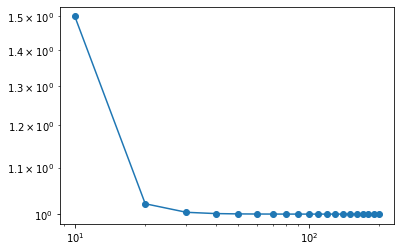

In [131]:
plt.plot(n_grids, errors, marker="o")
plt.xscale('log')
plt.yscale('log')

In [13]:
n_grids = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]


In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt

errors = []
for n_grid in n_grids:
    loss = torch.load('./poisson_results/loss_n_{}'.format(n_grid))
    errors.append(loss.detach().numpy())

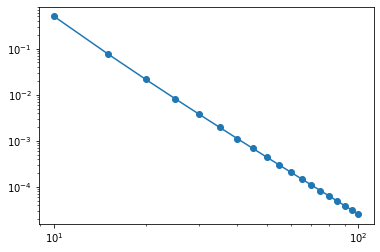

In [15]:
plt.plot(n_grids,errors,marker="o")
plt.xscale('log')
plt.yscale('log')

In [66]:
start_id = 0
end_id = -1
(np.log(errors[end_id])-np.log(errors[start_id]))/(np.log(n_grids[end_id]-1)-np.log(n_grids[start_id]-1))

-1.9222219464260804